In [66]:
import numpy as np
import pandas as pd

path = "avg/"
sub_path = "d7/500-dmsp.xlsx"

host_path = "data/algae/" + path + sub_path
bacteria_path = "data/bacteria/" + path + sub_path

df_host = pd.read_excel(host_path, header=None)
df_bacteria = pd.read_excel(bacteria_path, header=None)
df_bacteria = df_bacteria.replace(0, np.nan)

df_host_time = df_host.iloc[:, 0]
host = df_host.iloc[:, 1].tolist()

df_bacteria_time = df_bacteria.iloc[:, 0]
bacteria = df_bacteria.iloc[:, 1].tolist()

time = df_host_time.tolist()

log_host = np.log(np.array(host) + 1e-9)
log_bacteria = np.log(np.array(bacteria) + 1e-9)

save_path = "figures/0-path/" + host_path.replace("/", "_")
save_path = save_path[:-5].replace("data_algae_", "").strip()


In [67]:
def ode_system(t, y, params):
    H = y[0]
    B = y[1]

    muH = params[0]
    muB = params[1]
    k = params[2]

    dHdt = (muH * H * (1 - (H / k) ))
    dBdt = muB * B
    return [dHdt, dBdt]

In [68]:
import pytensor.tensor as pt
from pytensor.graph.op import Op
from scipy.integrate import solve_ivp

class SolveIVPWrapper(Op):
    itypes = [pt.dvector]  # theta + y0
    otypes = [pt.dmatrix]  # solution: (len(t), 3)

    def __init__(self, times):
        self.times = times

    def perform(self, node, inputs, outputs):
        theta_y0, = inputs
        theta = theta_y0[:3] # first 3
        y0 = theta_y0[3:] # last 2

        sol = solve_ivp(
            fun=lambda t, y: ode_system(t, y, theta),
            t_span=(self.times[0], self.times[-1]),
            y0=y0,
            t_eval=self.times,
            method="LSODA"
        )

        if not sol.success:
            raise RuntimeError("ODE solver failed:", sol.message)

        outputs[0][0] = sol.y.T  # shape: (time, 3)

In [69]:
import pymc as pm

ode_op = SolveIVPWrapper(time)

with pm.Model() as model:
    muH = pm.Uniform("muH", lower=0, upper=1)
    #muH = pm.Lognormal("muH", mu=np.log(0.85), sigma=.1)

    muB = pm.Uniform("muB", lower=0, upper=1)
    #muB = pm.Lognormal("muB", mu=np.log(0.5), sigma=.1) 
    
    k = pm.Uniform("k", lower=1e6, upper=2e7)
    #k = pm.Lognormal("k", mu=np.log(8.5e6), sigma=.1)

    H0 = pm.Uniform("H0", lower=2e5, upper=1e7)
    B0 = pm.Uniform("B0", lower=2e4, upper=1e7)
    
    sigma_host = pm.HalfNormal("sigma_host", sigma=1)
    sigma_bacteria = pm.HalfNormal("sigma_bacteria", sigma=1)

    ode_solution = ode_op(pt.stack([muH, muB, k, H0, B0]))

    pm.Normal(
        "host_obs",
        mu=pm.math.log(ode_solution[:, 0] + 1e-9),
        sigma=sigma_host,
        observed=log_host
    )

    pm.Normal(
        "bacteria_obs",
        mu=pm.math.log(ode_solution[:, 1] + 1e-9),
        sigma=sigma_bacteria,
        observed=log_bacteria
    )

In [70]:
with model:
    trace = pm.sample(draws=10000, 
                      tune=10000, 
                      step=pm.Metropolis(),
                      chains=4, 
                      cores=4, 
                      return_inferencedata=True, 
                     ) 

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [muH]
>Metropolis: [muB]
>Metropolis: [k]
>Metropolis: [H0]
>Metropolis: [B0]
>Metropolis: [sigma_host]
>Metropolis: [sigma_bacteria]


Output()

Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 126 seconds.


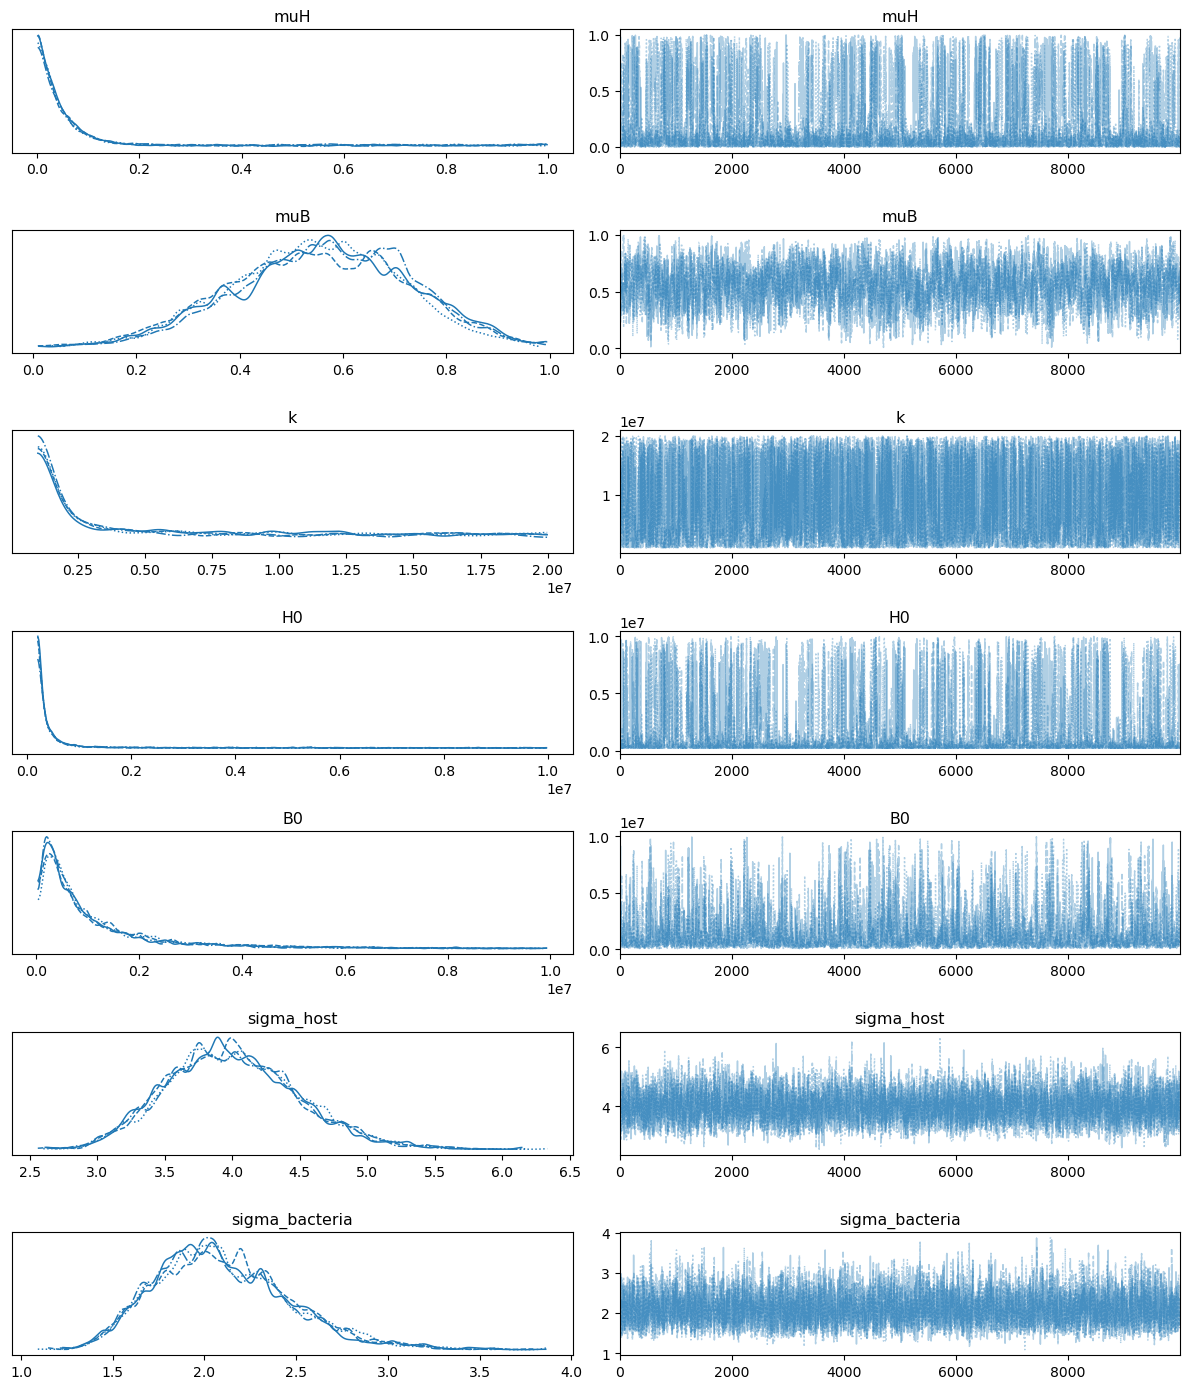

In [71]:
import matplotlib.pyplot as plt
import arviz as az
az.summary(
    trace,
    round_to=10
)

# Take note of ess_bulk and r_hat values

az.plot_trace(trace, 
              backend_kwargs={"tight_layout": True})
plt.savefig(save_path + "-trace.png")
plt.show()

## GPT 5 Induced

In [72]:
def simulate_ode_from_posterior(
    idata,
    time,
    ode_rhs,
    n_draws=100,
    random_seed=None,
):
    import numpy as np
    import arviz as az
    from scipy.integrate import solve_ivp

    rng = np.random.default_rng(random_seed)

    posterior = idata.posterior
    n_chains = posterior.sizes["chain"]
    n_draws_posterior = posterior.sizes["draw"]

    flat_idx = rng.integers(0, n_chains * n_draws_posterior, size=n_draws)
    chain_idx = flat_idx // n_draws_posterior
    draw_idx = flat_idx % n_draws_posterior

    time = np.asarray(time, dtype=float)
    t_span = (time[0], time[-1])

    sims = []

    for c, d in zip(chain_idx, draw_idx):
        muH0 = float(posterior["muH"].values[c, d])
        muB0 = float(posterior["muB"].values[c, d])
        k0      = float(posterior["k"].values[c, d])
        #phi0    = float(posterior["phi"].values[c, d])
        #beta0  = float(posterior["beta"].values[c, d])

        H00 = float(posterior["H0"].values[c, d])
        #P00 = float(posterior["P0"].values[c, d])
        B00 = float(posterior["B0"].values[c, d])

        params_vec = np.array([muH0, muB0, k0], dtype=float)
        y0 = [H00, B00]
        sol = solve_ivp(
            lambda t, y: ode_rhs(t, y, params_vec),
            t_span=t_span,
            y0=y0,
            t_eval=time,
            method="LSODA",   # or whatever stiff solver you like
            rtol=1e-6,
            atol=1e-8,
        )

        if not sol.success:
            sims.append(np.full((time.size, 3), np.nan))
        else:
            sims.append(sol.y.T)

    sims = np.stack(sims, axis=0)  # (n_draws, T, 3)
    return sims


In [73]:
import matplotlib.pyplot as plt

def plot_posterior_fit(
    idata,
    time,
    host,
    #d7,
    bacteria,
    ode_rhs,
    n_draws=200,
    log_scale=True,
    random_seed=None,
):
    """
    Plot posterior ODE trajectories over the observed data
    for Host, D7/Pathogen, and Bacteria.
    """
    time = np.asarray(time, dtype=float)
    host = np.asarray(host, dtype=float)
    #d7 = np.asarray(d7, dtype=float)
    bacteria = np.asarray(bacteria, dtype=float)

    sims = simulate_ode_from_posterior(
        idata,
        time,
        ode_rhs,
        n_draws=n_draws,
        random_seed=random_seed,
    )  # (n_draws, T, 3)

    fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 10))

    series = [host, bacteria]
    labels = ["Host", "Bacteria"]

    for i, ax in enumerate(axes):
        y_obs = series[i]
        y_sim = sims[:, :, i]  # (n_draws, T)

        if log_scale:
            y_obs_plot = np.log(y_obs + 1e-9)
            y_sim_plot = np.log(y_sim + 1e-9)
            ax.set_ylabel(f"log {labels[i]}")
        else:
            y_obs_plot = y_obs
            y_sim_plot = y_sim
            ax.set_ylabel(labels[i])

        # scatter observed data
        ax.scatter(time, y_obs_plot, marker="o", alpha=0.8)

        # posterior median and 90% band
        median = np.nanmedian(y_sim_plot, axis=0)
        lower, upper = np.nanpercentile(y_sim_plot, [5, 95], axis=0)

        ax.plot(time, median, linewidth=2)
        ax.fill_between(time, lower, upper, alpha=0.2)

        ax.grid(True, alpha=0.3)

    axes[-1].set_xlabel("Time")
    plt.tight_layout()
    return fig, axes


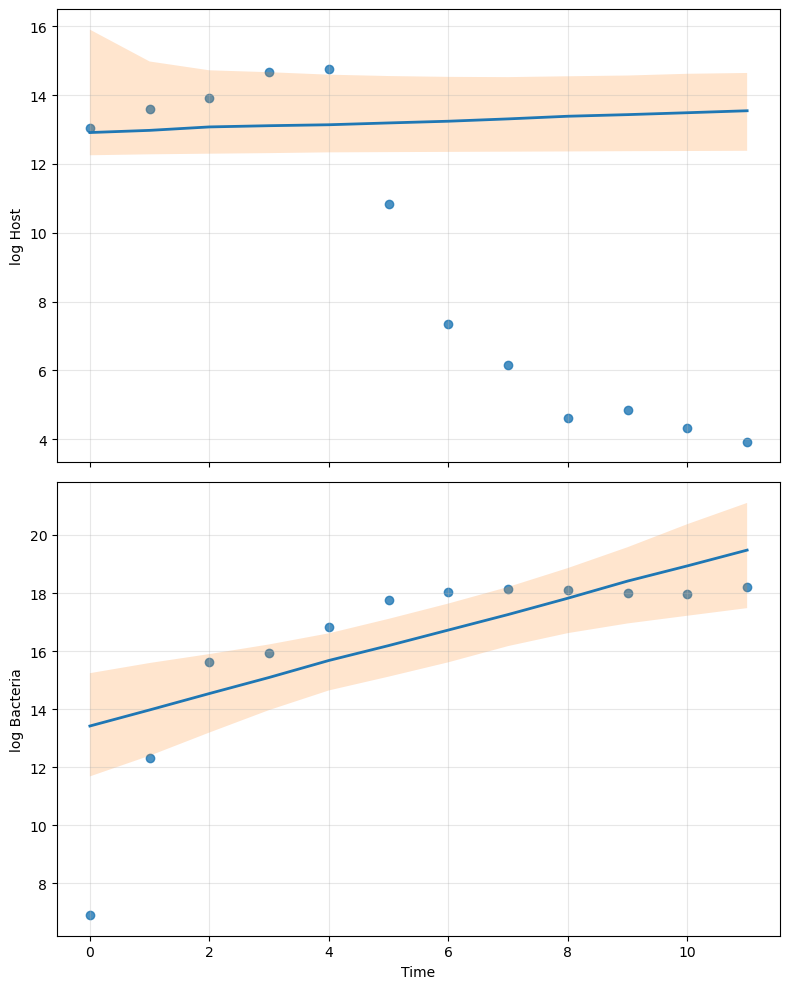

In [74]:
fig, axes = plot_posterior_fit(
    idata=trace,
    time=time,
    host=host,
    bacteria=bacteria,
    ode_rhs=ode_system,
    n_draws=200,
    log_scale=True,
    random_seed=42,
)
plt.savefig(save_path + "-posterior-fit.png")
plt.show()